In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich


from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [ ]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch

In [5]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter

from haystack.utils import Secret


document_store = InMemoryDocumentStore()


converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"converter": {"sources": ["../data/tolkien.txt",
                                                 "../data/George_RR_Martin.txt"]}})

No abbreviations file found for en. Using default abbreviations.
Batches: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


{'writer': {'documents_written': 92}}

In [6]:
rag_prompt_template = """
Answer the following query given the documents.
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "generator")


🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

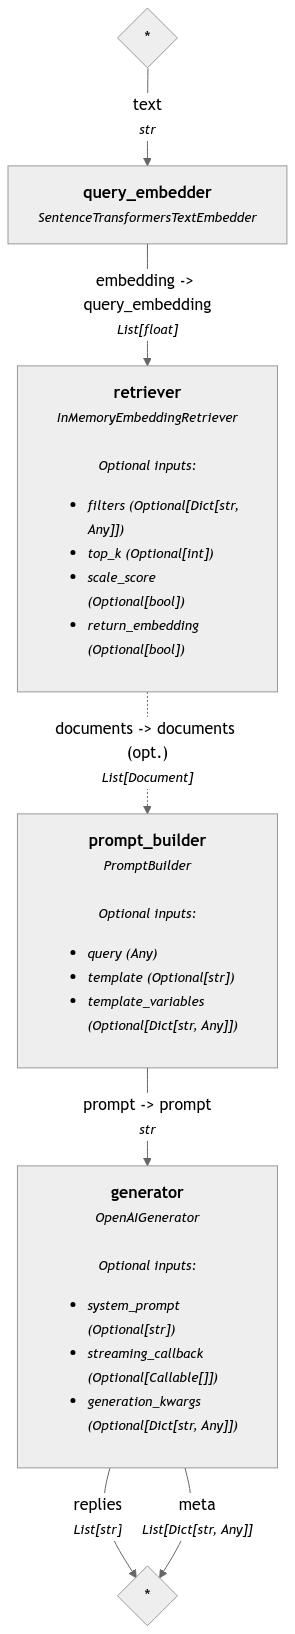

In [7]:
rag.show()

In [8]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"retriever"}
)


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.72it/s]

In [9]:
rich.print(result["generator"]["replies"][0])

J. R. R. Tolkien, whose full name is John Ronald Reuel Tolkien, was born on January 3, 1892, in Bloemfontein, South
Africa. He is widely regarded as one of the most influential and celebrated figures in literary history, 
particularly in the genre of high fantasy.

## Evaluate the Pipeline

For this tutorial, let's evaluate the pipeline with the following metrics since we don't have ground-truth labels:

- [ContextRelevace](https://docs.haystack.deepset.ai/docs/contextrelevanceevaluator): Uses an LLM to evaluate whether contexts are relevant to a question. It does not require ground truth labels.
- [Faithfulness](https://docs.haystack.deepset.ai/docs/faithfulnessevaluator): Uses an LLM to evaluate whether a generated answer can be inferred from the provided contexts. Does not require ground truth labels.


For a full list of available metrics, check out the [Haystack Evaluators](https://docs.haystack.deepset.ai/docs/)

In [10]:
from haystack import Pipeline
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator

eval_pipeline = Pipeline()
eval_pipeline.add_component("context_relevance", ContextRelevanceEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar=True, raise_on_failure=False))
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar = True, raise_on_failure=False))

In [11]:
questions = ["Who is Tolkien?", "What did Tolkien write?", "Which is the 'The Hobbit' plot?", 
             "Tell me somthing about 'The Lord of the Rings", "Who is George Martin?", "What is 'A Song of Ice and Fire'?",
             "Where George Martin was born?", "What about Game of Thrones?"]

In [12]:
predicted_answers = []
retrieved_context = []

for question in questions: # loops over questions
  result = rag.run({"query_embedder":{"text":question}, "prompt_builder":{"query": question}}, include_outputs_from={"retriever"})
  predicted_answers.append(result["generator"]["replies"][0])
  retrieved_context.append(result["retriever"]["documents"])

Batches: 100%|██████████| 1/1 [00:00<00:00, 33.40it/s]


In [13]:
predicted_answers

['John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential figures in literary history, particularly in the genre of high fantasy. He is best known for his works such as "The Hobbit" and "The Lord of the Rings," which established the fictional universe of Middle-earth and became pivotal in the development of modern fantasy literature.',
 'Tolkien wrote novels, essays, and letters. Notably, he is well-known for his works such as "The Hobbit" and the larger project of creating the world of Middle-earth.',
 "'The Hobbit' follows the adventures of Bilbo Baggins, a hobbit who is reluctantly drawn into a quest with a group of dwarves and the wizard Gandalf. The story begins when Bilbo is visited by Gandalf and the dwarves, who are seeking a burglar to help them reclaim their treasure from the dragon Smaug. Throughout the journey, Bilbo encounters various challenges and creatures, ultimately discovering courage and a 

In [14]:
retrieved_context

[[Document(id=25c02b8233568e2bb4ebc19c7ace18dba07d8090fa5eda89346c632467317d6d, content: 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarde...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d31875c841e2726f081097a061c8b5b88e123cc12f80c3', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 0.6804672258012565),
  Document(id=8aa5a0cc00768048dc46b692dfe162e23a298f60004d87b9ee31559ead6e459b, content: 'Tolkien, Robert E. Howard, and H.P. ', meta: {'file_path': 'George_RR_Martin.txt', 'source_id': '110c9ea253b56c8f028fa50060b64f3731095564c9cdd0f3d456235dc630cb40', 'page_number': 1, 'split_id': 5, 'split_idx_start': 822}, score: 0.6557155281646178),
  Document(id=52321e431aa3d3cbbe310f69c12b3f5ca96aba4ef7ed683fc155019601ea6c1d, content: 'The success of The Hobbit marked Tolkien’s emergence as a prominent author, and his creation of Midd...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d

In [15]:
eval_pipeline_results = eval_pipeline.run(
    {
        "context_relevance": {"questions": questions, "contexts": retrieved_context},
        "faithfulness": {"questions": questions, "contexts": retrieved_context, "predicted_answers": predicted_answers},
    }
)

results = {
    "context_relevance": eval_pipeline_results['context_relevance'],
    "faithfulness": eval_pipeline_results['faithfulness'],
}

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:24<00:00,  3.08s/it]


In [16]:
results

{'context_relevance': {'results': [{'relevant_statements': ['John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded...'],
    'score': 1},
   {'relevant_statements': ['Tolkien wrote essays and letters in which he discussed his creative process.',
     'The success of The Hobbit marked Tolkien’s emergence as a prominent author.'],
    'score': 1},
   {'relevant_statements': ['The story follows Bilbo Baggins, a hobbit who embarks on a thrilling adventure with a group of dwarv...'],
    'score': 1},
   {'relevant_statements': ['Published in three volumes between 1954 and 1955—The Fellowship of the Ring, The Two Towers, and The...'],
    'score': 1},
   {'relevant_statements': ['George Raymond Richard Martin, born on September 20, 1948, in Bayonne, New Jersey, is celebrated a...'],
    'score': 1},
   {'relevant_statements': ['In the early 1990s, Martin began work on what would become his magnum opus, A Song of Ice and Fire.'],
    'score': 1}

In [17]:
from haystack.evaluation import EvaluationRunResult

inputs = {
    'questions': questions,
    'contexts': retrieved_context,
    'predicted_answers': predicted_answers
}
run_name="rag_eval"
eval_results = EvaluationRunResult(run_name=run_name, inputs=inputs, results=results)
eval_results.score_report()

,metrics,score
0,context_relevance,1.000
1,faithfulness,0.975


In [18]:
eval_results.to_pandas()

,questions,contexts,predicted_answers,context_relevance,faithfulness
0,Who is Tolkien?,[Document(id=25c02b8233568e2bb4ebc19c7ace18dba...,"John Ronald Reuel Tolkien, born on January 3, ...",1,1.0
1,What did Tolkien write?,[Document(id=333fbde2e75366486f005bcc30cfa330b...,"Tolkien wrote novels, essays, and letters. Not...",1,1.0
2,Which is the 'The Hobbit' plot?,[Document(id=3917c7b05bc55534e39a21a4474f74c50...,'The Hobbit' follows the adventures of Bilbo B...,1,1.0
3,Tell me somthing about 'The Lord of the Rings,[Document(id=b727183327e833e6d25b912548514a701...,The Lord of the Rings is a high-fantasy epic p...,1,1.0
4,Who is George Martin?,[Document(id=d6540c0512af921b23158f0911910178f...,"George Raymond Richard Martin, born on Septemb...",1,1.0
5,What is 'A Song of Ice and Fire'?,[Document(id=fa03c0722148fa4114da26d1378e8a785...,'A Song of Ice and Fire' is a series of epic f...,1,0.8
6,Where George Martin was born?,[Document(id=d6540c0512af921b23158f0911910178f...,"George Martin was born in Bayonne, New Jersey.",1,1.0
7,What about Game of Thrones?,[Document(id=34219998cc1be713dfd3c5c82120766fa...,Game of Thrones refers to both the original bo...,1,1.0
